In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import os

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Unzip the dataset. This might take a minute.
# We extract it to /content/ for faster access during training.
print("--- Unzipping Dataset ---")
!unzip -q "/content/drive/MyDrive/BabyCryProject/Primary Image.zip" -d "/content/"
print("--- Unzipping Complete ---")

# Define the path to your extracted dataset folder
base_dir = '/content/Primary Image'

# Define image parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Create the training dataset (80% of the data)
train_dataset = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

# Create the initial validation dataset (the remaining 20%)
validation_dataset_initial = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

# Get the class names from the folder names
class_names = train_dataset.class_names
print("\nFound class names:", class_names)

# Split the validation set into two halves: one for validation and one for testing
val_batches = tf.data.experimental.cardinality(validation_dataset_initial)
test_dataset = validation_dataset_initial.take(val_batches // 2)
validation_dataset = validation_dataset_initial.skip(val_batches // 2)

print(f'\nNumber of training batches: {tf.data.experimental.cardinality(train_dataset)}')
print(f'Number of validation batches: {tf.data.experimental.cardinality(validation_dataset)}')
print(f'Number of test batches: {tf.data.experimental.cardinality(test_dataset)}')

--- Unzipping Dataset ---
--- Unzipping Complete ---
Found 1600 files belonging to 4 classes.
Using 1280 files for training.
Found 1600 files belonging to 4 classes.
Using 320 files for validation.

Found class names: ['Angry', 'Cry', 'Laugh', 'Normal']

Number of training batches: 40
Number of validation batches: 5
Number of test batches: 5


In [4]:
# Configure the dataset for optimal performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [14]:
# --- Updated Custom CNN Model with a Fine-Tuned Learning Rate ---

# We still use the same data augmentation layer
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
])

model = Sequential([
    # Input layer
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    # Apply data augmentation
    data_augmentation,

    # Rescale pixel values from [0, 255] to [0, 1]
    tf.keras.layers.Rescaling(1./255),

    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten the results to feed into a dense layer
    Flatten(),

    # Dense layer for learning complex patterns
    Dense(512, activation='relu'),
    # Dropout layer to prevent overfitting
    Dropout(0.5),

    # Output layer with a node for each class
    Dense(len(class_names), activation='softmax')
])

# !!! THIS IS THE UPDATED PART !!!
# Use the Adam optimizer with a specific, smaller learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compile the model with the new optimizer
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print a summary of the new architecture
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,398,148 (169.37 MB)

 Trainable params: 44,398,148 (169.37 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
def train_and_plot_history(model, train_data, val_data, epochs):
    """
    Trains the model and plots the training/validation accuracy and loss.
    """
    print("--- Starting Model Training ---")
    # Train the model and store the history
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs
    )
    print("--- Model Training Finished ---")

    # Get accuracy and loss from the model's history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(epochs)

    # Create subplots for accuracy and loss
    plt.figure(figsize=(12, 5))

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

    return history

--- Starting Model Training ---
Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.2334 - loss: 1.4950 - val_accuracy: 0.3562 - val_loss: 1.3724
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.2899 - loss: 1.3757 - val_accuracy: 0.3875 - val_loss: 1.3408
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.3589 - loss: 1.3433 - val_accuracy: 0.3875 - val_loss: 1.3157
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.3440 - loss: 1.3308 - val_accuracy: 0.3750 - val_loss: 1.2877
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.3643 - loss: 1.3241 - val_accuracy: 0.4062 - val_loss: 1.3225
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.3442 - loss: 1.3097 - val_accuracy: 0.4500 - val_loss: 1.2885
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.3955 - loss: 1.2793 - val_accuracy: 0.3812 - val_loss: 1.3206
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.3798 - loss: 1.2786 - 

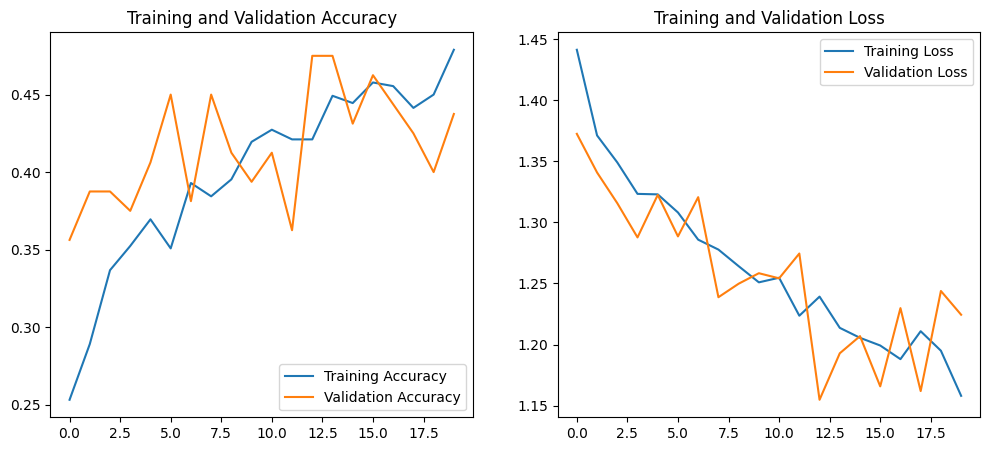

In [16]:
# Set the number of epochs to train for
NUM_EPOCHS = 20

# Call the function to train the model and plot the results
history = train_and_plot_history(model, train_dataset, validation_dataset, NUM_EPOCHS)

In [17]:
print("\n--- Evaluating Model on Test Data ---")

# The model.evaluate() function returns the loss and the accuracy
loss, accuracy = model.evaluate(test_dataset)

print(f"\nTest Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss:.4f}")


--- Evaluating Model on Test Data ---
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4661 - loss: 1.1704

Test Accuracy: 46.88%
Test Loss: 1.1797


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


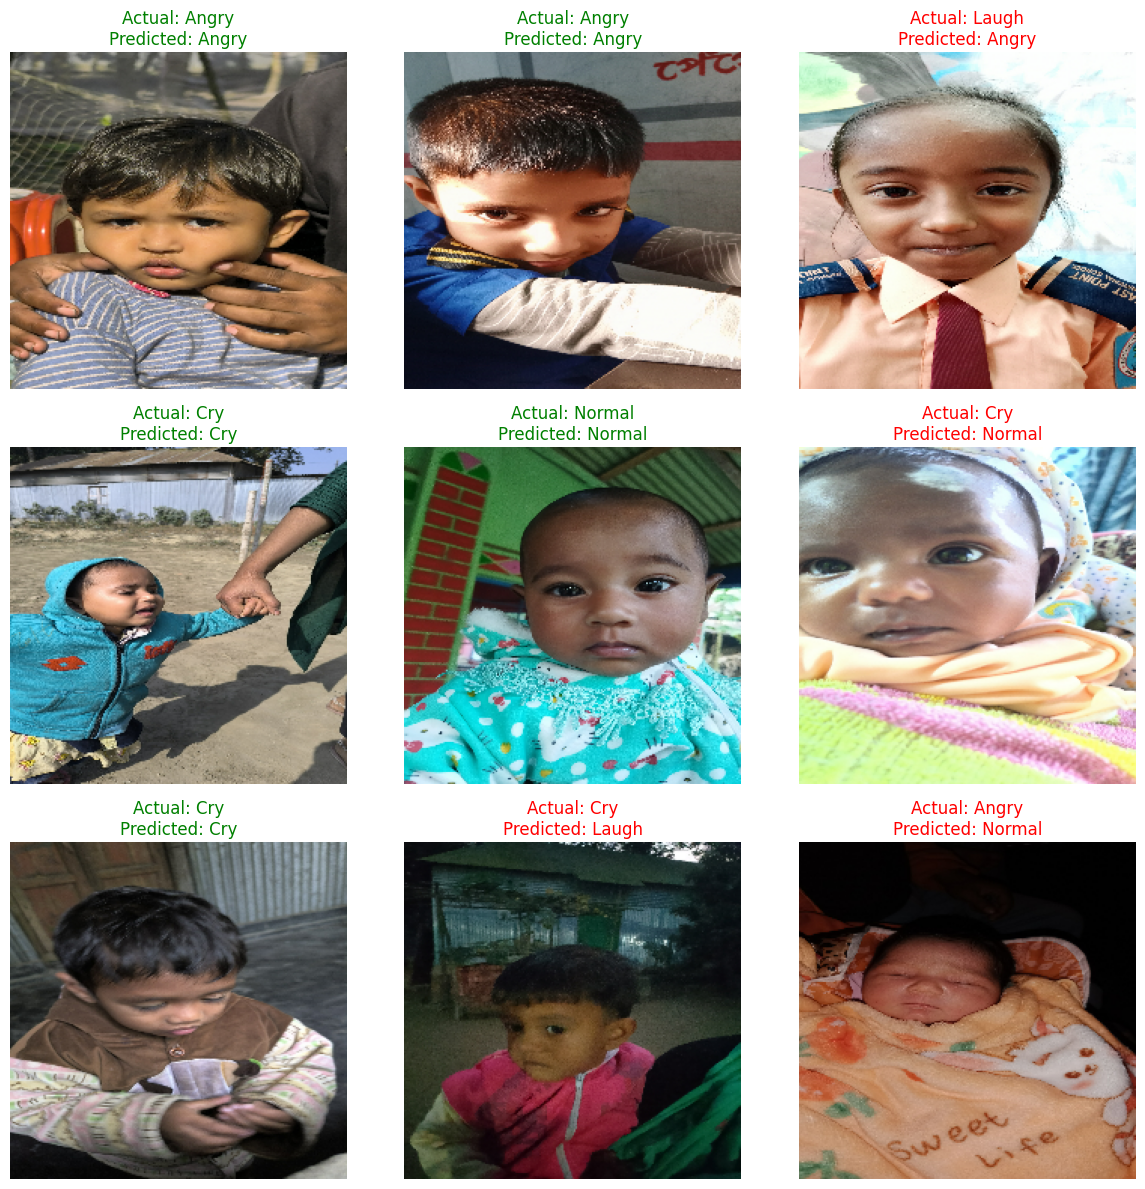

In [18]:
# --- Visualize Model Predictions on Test Images ---

# Retrieve a batch of images and labels from the test set
image_batch, label_batch = next(iter(test_dataset))

# Make predictions on the entire batch
predictions = model.predict(image_batch)

# Set up the plot to display 9 images
plt.figure(figsize=(12, 12))
for i in range(9):
    # Create a subplot for each image
    ax = plt.subplot(3, 3, i + 1)

    # Display the image
    plt.imshow(image_batch[i].numpy().astype("uint8"))

    # Get the predicted class name
    predicted_class_index = np.argmax(predictions[i])
    predicted_class = class_names[predicted_class_index]

    # Get the actual class name
    actual_class = class_names[label_batch[i]]

    # Set the title with the prediction and actual label
    # Color the title green for correct predictions and red for incorrect ones
    if predicted_class == actual_class:
        title_color = 'green'
    else:
        title_color = 'red'

    plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}", color=title_color)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [20]:
# Define the full path to save the model in your Google Drive
drive_model_path = '/content/drive/MyDrive/BabyCryProject/baby_emotion_classifier.keras'

# Save the entire model to the specified path
model.save(drive_model_path)

print(f"Model saved successfully to your Google Drive at: {drive_model_path}")

Model saved successfully to your Google Drive at: /content/drive/MyDrive/BabyCryProject/baby_emotion_classifier.keras
